In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
bike = pd.read_csv('day.csv')

In [3]:
bike.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
bike.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [6]:
bike.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [7]:
# drop the columns which are not at all required and won't impact the prediction in any way
# 1. casual  + registered = cnt, so we can drop the two columns
# 2. instant -> just the index

bike = bike.drop(['instant', 'casual', 'registered'], axis = 1)
bike.columns

Index(['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

#### As the dataset is diverse, let's try to breakdown the data cleaning process column by column

In [8]:
bike['mnth'].value_counts()

mnth
1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: count, dtype: int64

In [9]:
def object_map(x):
    return x.map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul',8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov',12: 'Dec'})

# Applying the function to the two columns
bike[['mnth']] = bike[['mnth']].apply(object_map)

In [10]:
bike.head(2)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,1,0,Jan,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,1,0,Jan,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801


In [11]:
bike['workingday'].value_counts()

workingday
1    504
0    226
Name: count, dtype: int64

In [12]:
bike['weekday'].value_counts()

weekday
1    105
2    105
3    104
4    104
5    104
6    104
0    104
Name: count, dtype: int64

In [13]:
def obj(x):
    return x.map({1: 'Mon', 2: 'Tues', 3: 'Wed', 4: 'Thurs', 5: 'Fri', 6: 'Sat', 0: 'Sun'})

bike['weekday'] = bike[['weekday']].apply(obj)

In [14]:
bike.head(2)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,1,0,Jan,0,Mon,1,2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,1,0,Jan,0,Tues,1,2,14.902598,17.68695,69.6087,16.652113,801


In [15]:
bike['season'].value_counts()

season
3    188
2    184
1    180
4    178
Name: count, dtype: int64

In [16]:
def obj(x):
    return x.map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})

bike['season'] = bike[['season']].apply(obj)

In [17]:
bike.head(2)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,spring,0,Jan,0,Mon,1,2,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,spring,0,Jan,0,Tues,1,2,14.902598,17.68695,69.6087,16.652113,801


In [18]:
bike['weathersit'].value_counts()

weathersit
1    463
2    246
3     21
Name: count, dtype: int64

In [19]:
bike['weathersit'] = bike['weathersit'].map({1: 'clear', 2: 'mist', 3: 'light_rain', 4: 'heavy_rain'})

In [20]:
bike.head(2)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01-01-2018,spring,0,Jan,0,Mon,1,mist,14.110847,18.18125,80.5833,10.749882,985
1,02-01-2018,spring,0,Jan,0,Tues,1,mist,14.902598,17.68695,69.6087,16.652113,801


### Visualising the data

In [21]:
bike['cnt'] = bike['cnt'].astype('float')

In [22]:
bike_numeric = bike.select_dtypes(include=['float64'])

In [23]:
x = bike_numeric.columns
x

Index(['temp', 'atemp', 'hum', 'windspeed', 'cnt'], dtype='object')

In [24]:
bike_categorical = bike.select_dtypes(exclude=['float64'])

In [25]:
y = bike_categorical.columns
y

Index(['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit'],
      dtype='object')

In [26]:
# visualising the numerical data
bike[x].corr()

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.991696,0.128565,-0.158186,0.627044
atemp,0.991696,1.000000,0.141512,-0.183876,0.630685
hum,0.128565,0.141512,1.000000,-0.248506,-0.098543
windspeed,-0.158186,-0.183876,-0.248506,1.000000,-0.235132
cnt,0.627044,0.630685,-0.098543,-0.235132,1.000000


<Axes: >

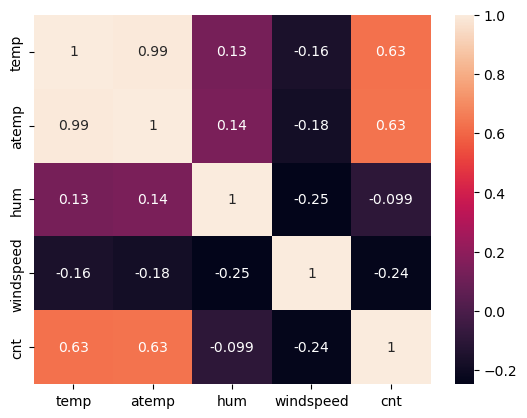

In [27]:
sns.heatmap(bike[x].corr(), annot = True)

- dropping atemp as it highly correlated to temp, and further has the highest correlation with cnt as well - multicollinearity

In [28]:
bike = bike.drop(['atemp'], axis = 1)

In [29]:
bike.head(1)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,01-01-2018,spring,0,Jan,0,Mon,1,mist,14.110847,80.5833,10.749882,985.0


In [31]:
# dropping dteday column as it does not affect the analysis or prediction in any way
bike = bike.drop(['dteday'], axis = 1)

<Axes: xlabel='weekday', ylabel='cnt'>

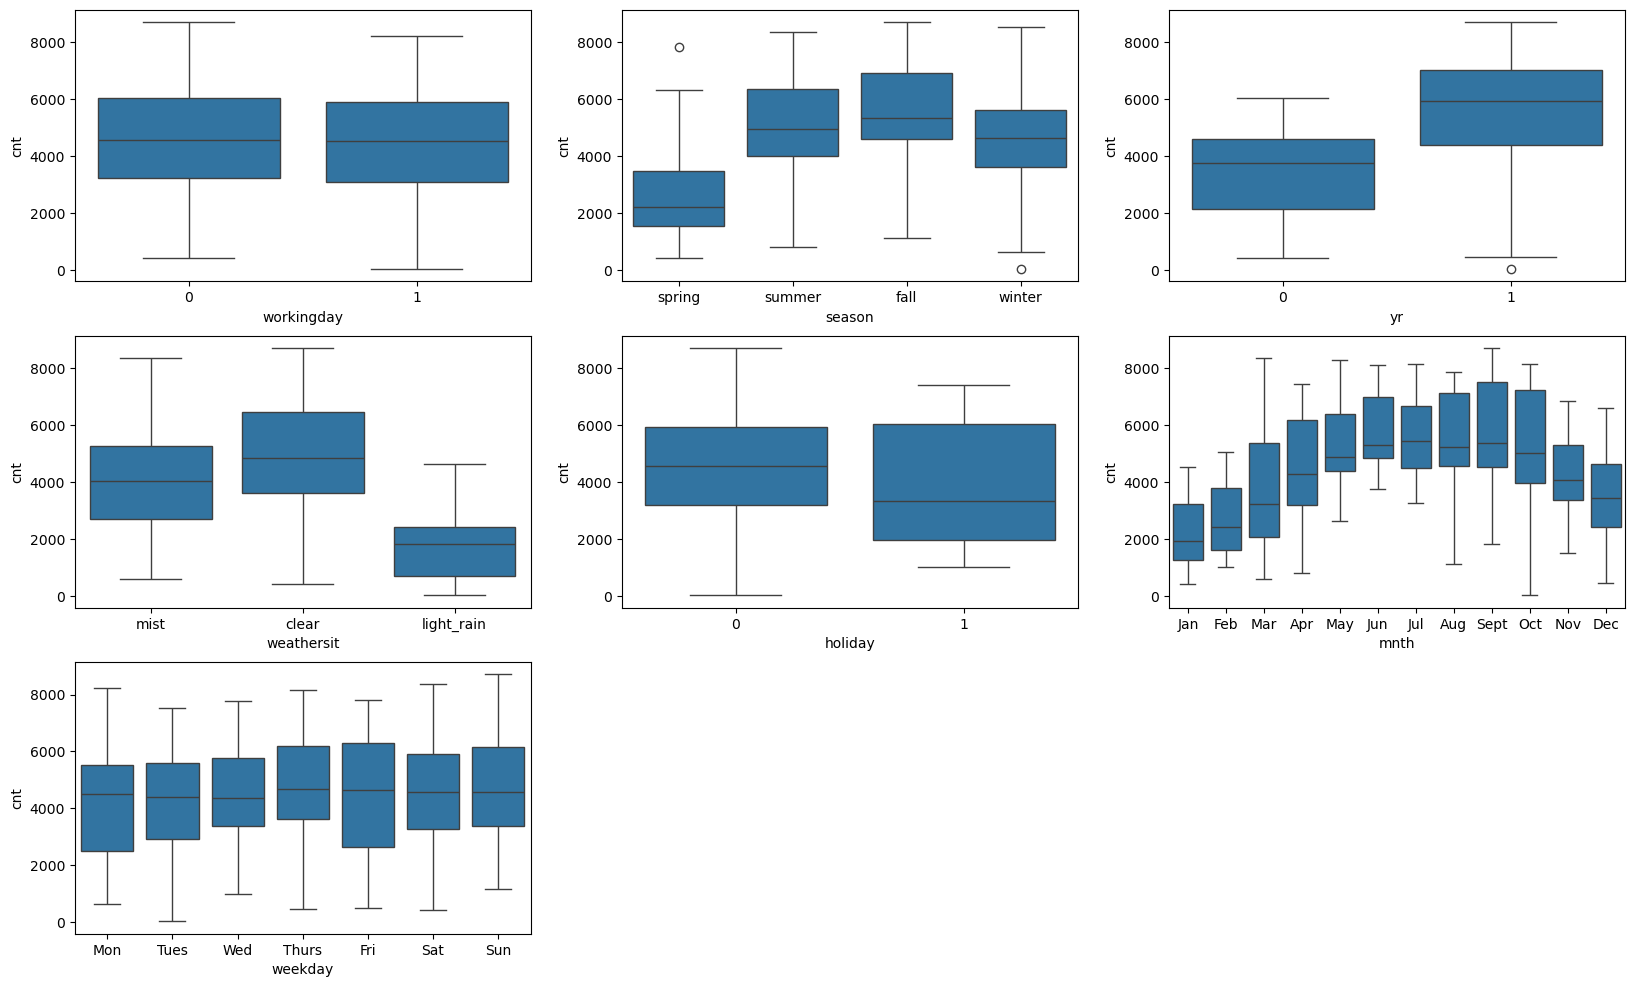

In [32]:
# visualising the categorical variables

plt.figure(figsize=(20,12))
plt.subplot(3,3,1)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike)
plt.subplot(3,3,2)
sns.boxplot(x = 'season', y = 'cnt', data = bike)
plt.subplot(3,3,3)
sns.boxplot(x = 'yr', y = 'cnt', data = bike)
plt.subplot(3,3,4)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike)
plt.subplot(3,3,5)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike)
plt.subplot(3,3,6)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike)
plt.subplot(3,3,7)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike)

### Converting categorical data to dummies

In [34]:
y = y.drop(['dteday'])

In [35]:
categorical = pd.get_dummies(bike[y], dtype= int, drop_first= True)

In [36]:
categorical.head(2)

,yr,holiday,workingday,season_spring,season_summer,season_winter,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,...,mnth_Oct,mnth_Sept,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed,weathersit_light_rain,weathersit_mist
0,0,0,1,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1


In [37]:
bike = bike.drop(y, axis = 1)

In [38]:
bike.columns

Index(['temp', 'hum', 'windspeed', 'cnt'], dtype='object')

In [39]:
bike = pd.concat([bike, categorical], axis = 1)

In [40]:
bike.head(2)

,temp,hum,windspeed,cnt,yr,holiday,workingday,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sept,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed,weathersit_light_rain,weathersit_mist
0,14.110847,80.5833,10.749882,985.0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,14.902598,69.6087,16.652113,801.0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [41]:
bike.columns

Index(['temp', 'hum', 'windspeed', 'cnt', 'yr', 'holiday', 'workingday',
       'season_spring', 'season_summer', 'season_winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sept', 'weekday_Mon',
       'weekday_Sat', 'weekday_Sun', 'weekday_Thurs', 'weekday_Tues',
       'weekday_Wed', 'weathersit_light_rain', 'weathersit_mist'],
      dtype='object')

### Train test split

In [42]:
df_train, df_test = train_test_split(bike, train_size=0.7, random_state=100)

In [43]:
print(df_train.shape, df_test.shape)

(510, 29) (220, 29)


### Standardising the data using MinMaxScaler

In [44]:
x

Index(['temp', 'atemp', 'hum', 'windspeed', 'cnt'], dtype='object')

In [45]:
y

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit'],
      dtype='object')

In [46]:
x = x.drop('atemp')

In [47]:
scaler = MinMaxScaler()

df_train[x] = scaler.fit_transform(df_train[x])
df_train.head(2)

,temp,hum,windspeed,cnt,yr,holiday,workingday,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sept,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed,weathersit_light_rain,weathersit_mist
576,0.815169,0.725633,0.264686,0.827658,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
426,0.442393,0.640189,0.255342,0.465255,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


<Axes: >

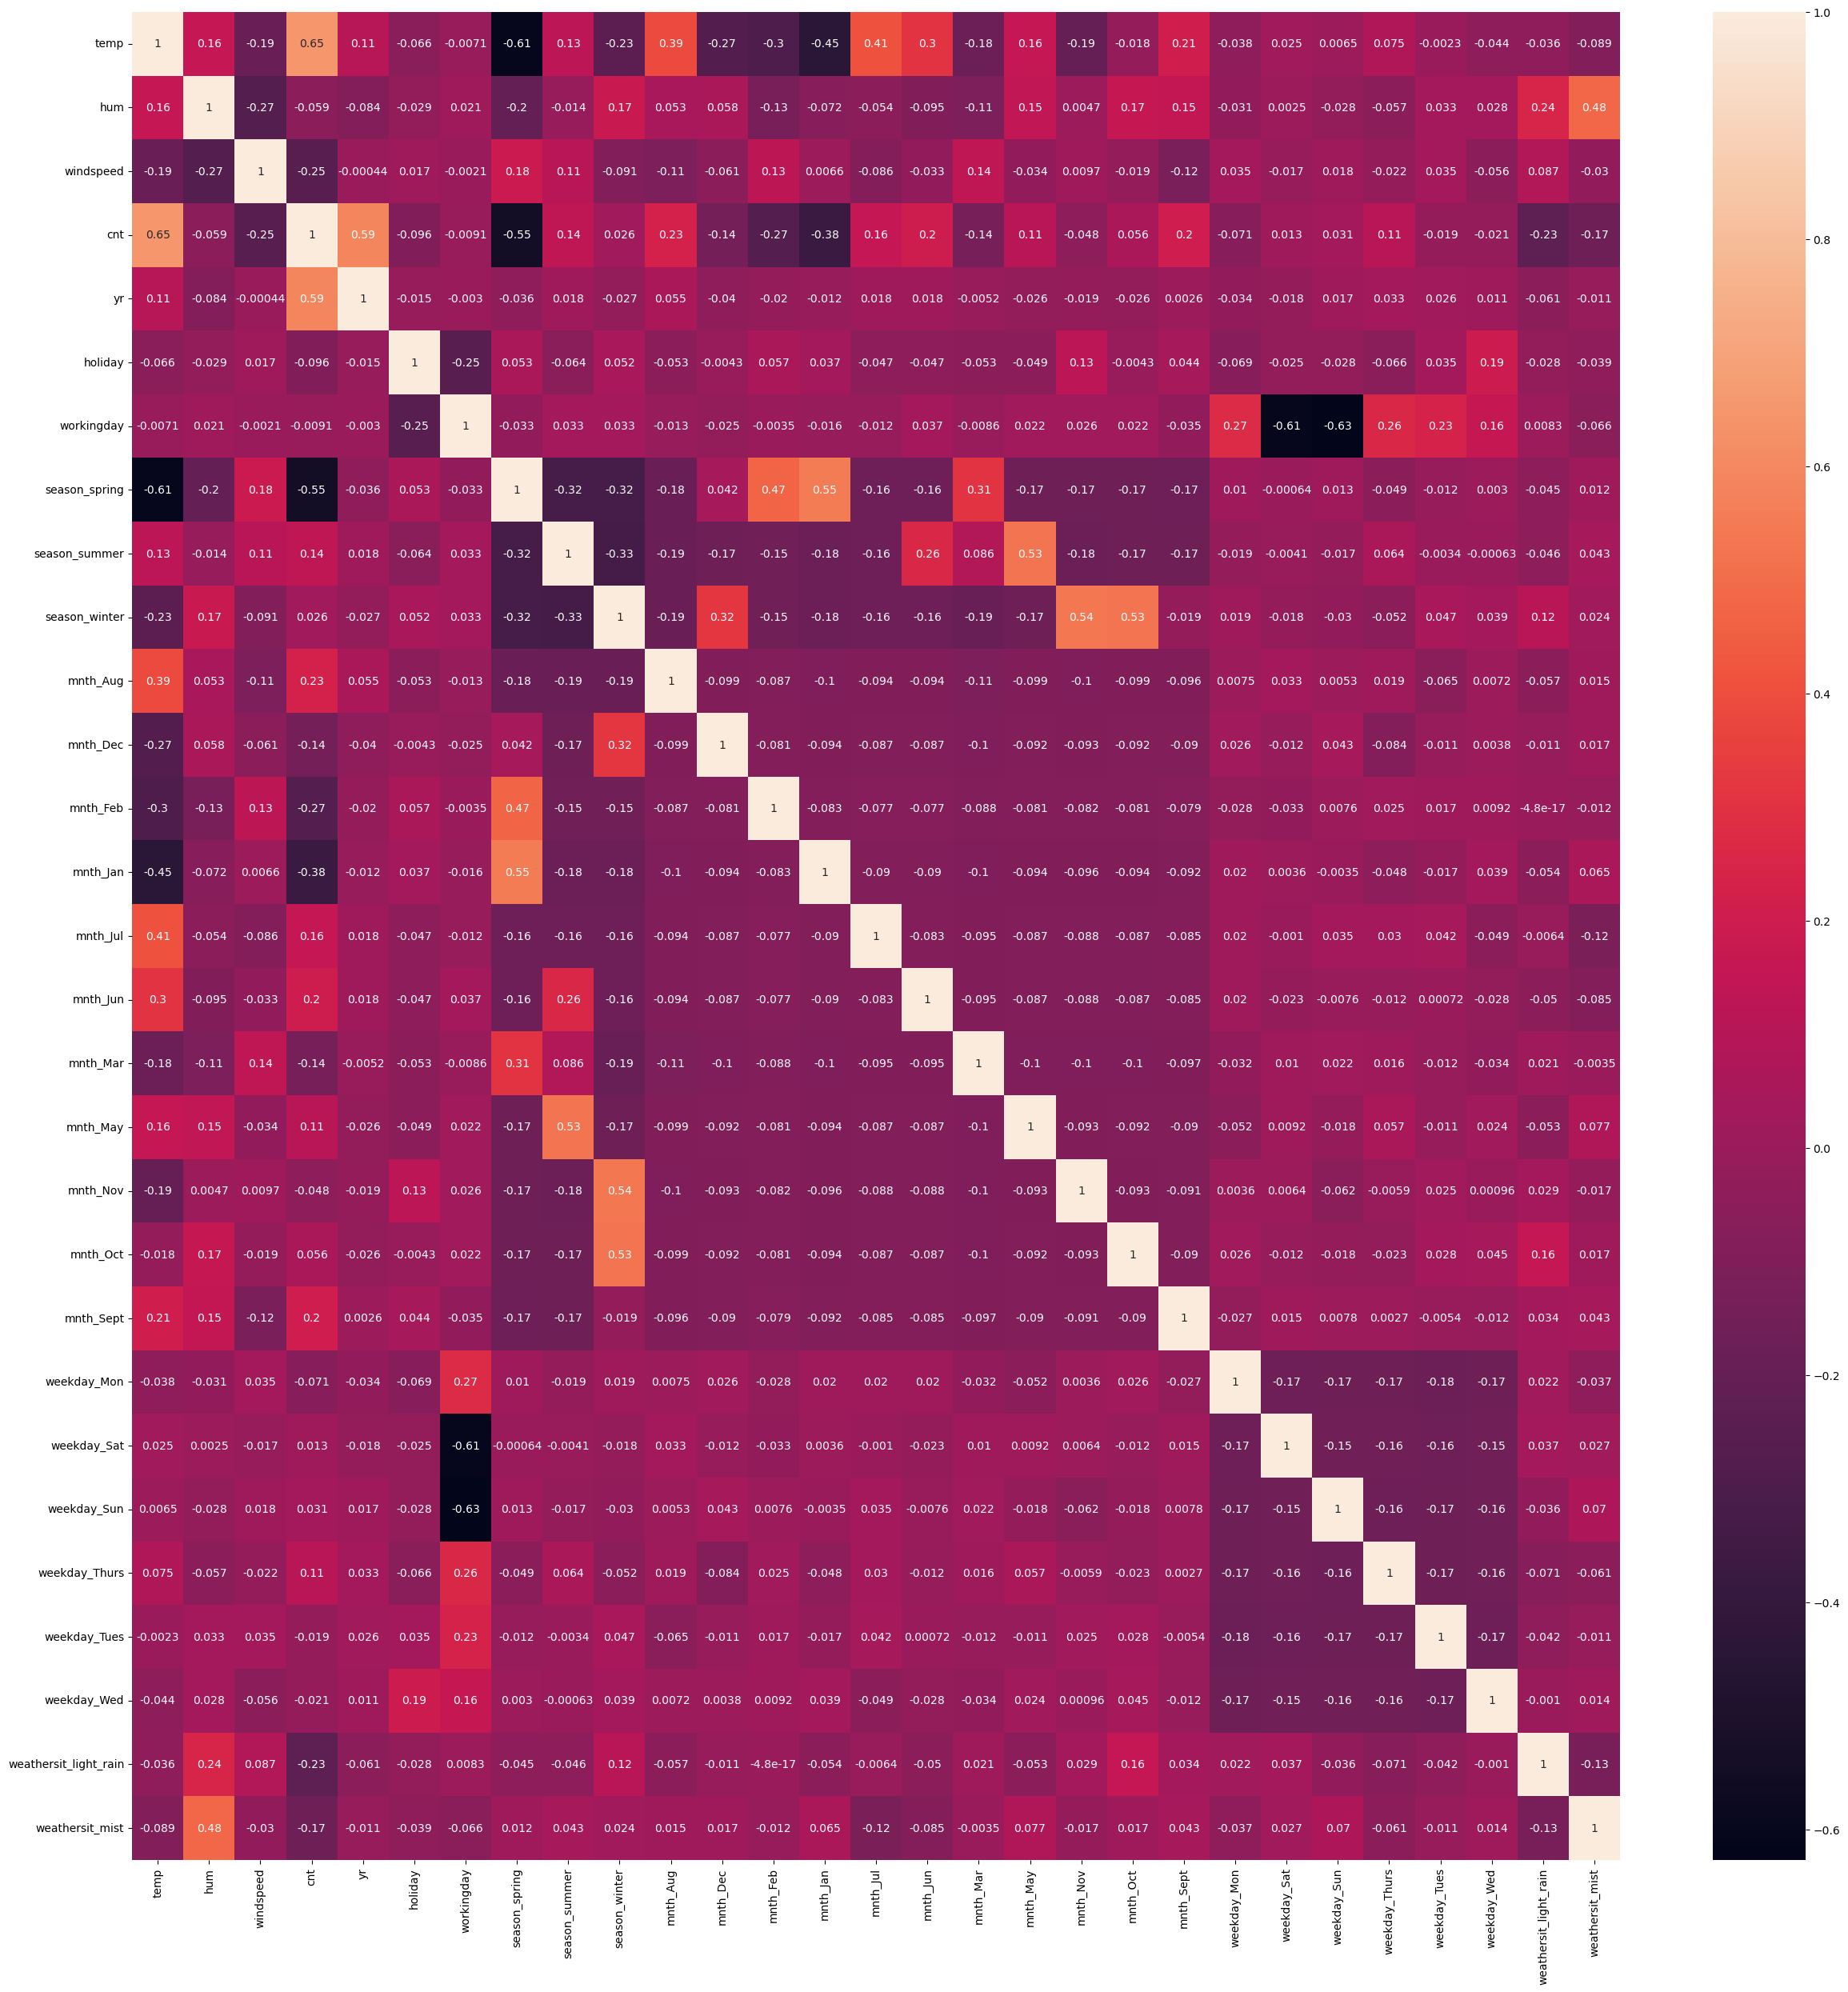

In [48]:
plt.figure(figsize = (30, 30))
sns.heatmap(df_train.corr(), annot=True)

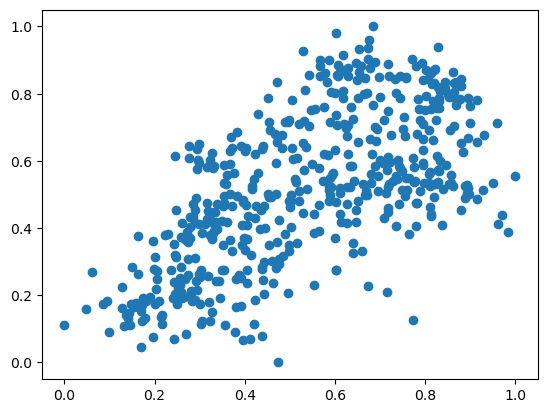

In [49]:
# temp and yr are highly correlated to cnt
plt.scatter(df_train['temp'], df_train['cnt']) 

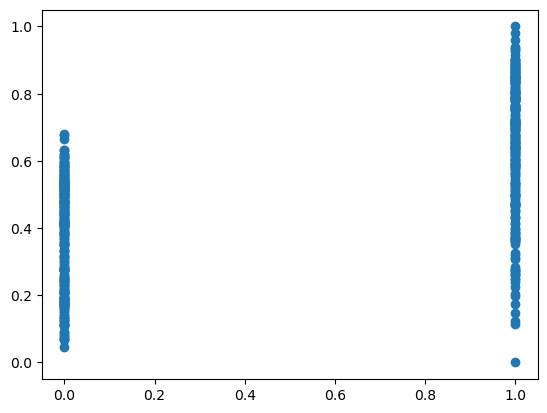

In [50]:
plt.scatter(df_train['yr'], df_train['cnt']) 

In [51]:
y_train = df_train.pop('cnt')
X_train = df_train

In [52]:
y_train.head(2)

576    0.827658
426    0.465255
Name: cnt, dtype: float64

In [53]:
X_train.head(2)

,temp,hum,windspeed,yr,holiday,workingday,season_spring,season_summer,season_winter,mnth_Aug,...,mnth_Oct,mnth_Sept,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed,weathersit_light_rain,weathersit_mist
576,0.815169,0.725633,0.264686,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
426,0.442393,0.640189,0.255342,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1


#### Initial model building using all the predictor variables, then using RFE to get 15 variables

In [54]:
X_train_lm = sm.add_constant(X_train)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     97.49
Date:                Tue, 30 Jul 2024   Prob (F-statistic):          1.34e-178
Time:                        20:48:53   Log-Likelihood:                 522.99
No. Observations:                 510   AIC:                            -988.0
Df Residuals:                     481   BIC:                            -865.2
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3912      0.085      4.594      0.000       0.224       0.558
temp                      0.4405      0.047      9.412      0.000       0.349       0.532
hum                      -0.1574      0.039     -4.043      0.000      -0.234      -0.081
windspeed                -0.1825      0.026     -7.003      0.000      -0.234      -0.131
yr                        0.2311      0.008     28.384      0.000       0.215       0.247
holiday                  -0.1348      0.065     -2.059      0.040      -0.263      -0.006
workingday               -0.0600      0.071     -0.844      0.399      -0.200       0.080
season_spring            -0.0404      0.030     -1.335      0.182      -0.100       0.019
season_summer             0.0464      0.026      1.761      0.079      -0.005       0.098
season_winter             0.1126      0.028      3.994      0.000       0.057       0.168
mnth_Aug                  0.0273      0.034      0.806      0.421      -0.039       0.094
mnth_Dec                 -0.0444      0.034     -1.309      0.191      -0.111       0.022
mnth_Feb                 -0.0374      0.033     -1.123      0.262      -0.103       0.028
mnth_Jan                 -0.0642      0.034     -1.894      0.059      -0.131       0.002
mnth_Jul                 -0.0285      0.035     -0.808      0.420      -0.098       0.041
mnth_Jun                  0.0084      0.025      0.336      0.737      -0.041       0.058
mnth_Mar                  0.0008      0.025      0.032      0.974      -0.048       0.050
mnth_May                  0.0247      0.021      1.164      0.245      -0.017       0.066
mnth_Nov                 -0.0396      0.037     -1.077      0.282      -0.112       0.033
mnth_Oct                  0.0056      0.036      0.156      0.876      -0.066       0.077
mnth_Sept                 0.0908      0.032      2.822      0.005       0.028       0.154
weekday_Mon              -0.0246      0.015     -1.687      0.092      -0.053       0.004
weekday_Sat              -0.0557      0.072     -0.777      0.437      -0.197       0.085
weekday_Sun              -0.0495      0.072     -0.691      0.490      -0.190       0.091
weekday_Thurs             0.0042      0.015      0.282      0.778      -0.025       0.034
weekday_Tues             -0.0261      0.015     -1.774      0.077      -0.055       0.003
weekday_Wed              -0.0102      0.015     -0.669      0.504      -0.040       0.020
weathersit_light_rain    -0.2499      0.027     -9.380      0.000      -0.302      -0.198
weathersit_mist          -0.0578      0.011     -5.495      0.000      -0.079      -0.037
==============================================================================
Omnibus:                       78.047   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarqu

In [55]:
# RFE

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm , n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [56]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 3),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('mnth_Aug', False, 9),
 ('mnth_Dec', True, 1),
 ('mnth_Feb', False, 2),
 ('mnth_Jan', True, 1),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 11),
 ('mnth_Mar', False, 14),
 ('mnth_May', False, 8),
 ('mnth_Nov', True, 1),
 ('mnth_Oct', False, 12),
 ('mnth_Sept', True, 1),
 ('weekday_Mon', False, 7),
 ('weekday_Sat', False, 4),
 ('weekday_Sun', False, 5),
 ('weekday_Thurs', False, 13),
 ('weekday_Tues', False, 6),
 ('weekday_Wed', False, 10),
 ('weathersit_light_rain', True, 1),
 ('weathersit_mist', True, 1)]

In [57]:
col = X_train.columns[rfe.support_]
col

Index(['temp', 'hum', 'windspeed', 'yr', 'holiday', 'season_spring',
       'season_summer', 'season_winter', 'mnth_Dec', 'mnth_Jan', 'mnth_Jul',
       'mnth_Nov', 'mnth_Sept', 'weathersit_light_rain', 'weathersit_mist'],
      dtype='object')

In [58]:
X_train_rfe = X_train[col]

In [59]:
X_train_new = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train, X_train_new).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.4
Date:                Tue, 30 Jul 2024   Prob (F-statistic):          8.15e-189
Time:                        20:48:56   Log-Likelihood:                 514.19
No. Observations:                 510   AIC:                            -996.4
Df Residuals:                     494   BIC:                            -928.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.31

- After dropping the features using RFE, the accuracy remains the same, which means the RFE performed well. Let's try checking the VIF values, post which we can use RFE to bring down the number of features to half

In [60]:
a=X_train_new.drop('const',axis=1)

In [61]:
vif = pd.DataFrame()
vif['Features'] = a.columns
vif['VIF'] = [variance_inflation_factor(a.values, i) for i in range(a.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Features,VIF
1,hum,30.89
0,temp,17.79
2,windspeed,4.72
5,season_spring,4.37
7,season_winter,4.06
6,season_summer,2.82
14,weathersit_mist,2.32
3,yr,2.09
11,mnth_Nov,1.85
9,mnth_Jan,1.75


- The VIF value for hum ,temp is greater than 5 which means that dropping these two predictor variables might not affect the overall R squared value

In [62]:
# RFE

lm1 = LinearRegression()
lm1.fit(X_train, y_train)

rfe1 = RFE(lm1 , n_features_to_select=7)
rfe1 = rfe1.fit(X_train, y_train)

In [63]:
list(zip(X_train.columns, rfe1.support_, rfe1.ranking_))

[('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 11),
 ('season_spring', False, 5),
 ('season_summer', False, 3),
 ('season_winter', True, 1),
 ('mnth_Aug', False, 17),
 ('mnth_Dec', False, 9),
 ('mnth_Feb', False, 10),
 ('mnth_Jan', False, 7),
 ('mnth_Jul', False, 4),
 ('mnth_Jun', False, 19),
 ('mnth_Mar', False, 22),
 ('mnth_May', False, 16),
 ('mnth_Nov', False, 8),
 ('mnth_Oct', False, 20),
 ('mnth_Sept', False, 2),
 ('weekday_Mon', False, 15),
 ('weekday_Sat', False, 12),
 ('weekday_Sun', False, 13),
 ('weekday_Thurs', False, 21),
 ('weekday_Tues', False, 14),
 ('weekday_Wed', False, 18),
 ('weathersit_light_rain', True, 1),
 ('weathersit_mist', False, 6)]

In [64]:
col1 = X_train.columns[rfe1.support_]
col1

Index(['temp', 'hum', 'windspeed', 'yr', 'holiday', 'season_winter',
       'weathersit_light_rain'],
      dtype='object')

In [65]:
X_train_rfe1 = X_train[col1]

In [66]:
X_train_new1 = sm.add_constant(X_train_rfe1)

lm2 = sm.OLS(y_train, X_train_new1).fit()

print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     281.5
Date:                Tue, 30 Jul 2024   Prob (F-statistic):          2.78e-169
Time:                        20:49:01   Log-Likelihood:                 445.46
No. Observations:                 510   AIC:                            -874.9
Df Residuals:                     502   BIC:                            -841.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.25

In [67]:
b = X_train_new1.drop(['const'], axis = 1)

In [68]:
vif = pd.DataFrame()
vif['Features'] = b.columns
vif['VIF'] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Features,VIF
1,hum,9.80
0,temp,6.87
2,windspeed,3.42
3,yr,2.01
5,season_winter,1.48
6,weathersit_light_rain,1.08
4,holiday,1.03


- hum and temp values are more than 5 let's see if dropping the two variables will have any affect on the r squared

In [69]:
X_train_new1 = X_train_new1.drop(['hum', 'temp'], axis = 1)

In [70]:
X_train_new2 = sm.add_constant(X_train_new1)

lm3 = sm.OLS(y_train, X_train_new2).fit()

print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     83.25
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           1.20e-63
Time:                        20:49:04   Log-Likelihood:                 192.42
No. Observations:                 510   AIC:                            -372.8
Df Residuals:                     504   BIC:                            -347.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.48

- did a mistake by dropping both the variables together, let's try dropping the hum column first

In [71]:
X_train_new3 = X_train[col1]
X_train_new3.columns

Index(['temp', 'hum', 'windspeed', 'yr', 'holiday', 'season_winter',
       'weathersit_light_rain'],
      dtype='object')

In [72]:
X_train_new3 = X_train_new3.drop(['hum'], axis = 1)

In [73]:
X_train_new4 = sm.add_constant(X_train_new3)

lm4 = sm.OLS(y_train, X_train_new4).fit()

print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     292.4
Date:                Tue, 30 Jul 2024   Prob (F-statistic):          1.93e-160
Time:                        20:49:06   Log-Likelihood:                 421.78
No. Observations:                 510   AIC:                            -829.6
Df Residuals:                     503   BIC:                            -799.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.10

In [74]:
c = X_train_new4.drop(['const'], axis = 1)

In [75]:
vif = pd.DataFrame()
vif['Features'] = c.columns
vif['VIF'] = [variance_inflation_factor(c.values, i) for i in range(c.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending=False)
vif

,Features,VIF
0,temp,3.07
1,windspeed,2.81
2,yr,2.00
4,season_winter,1.24
5,weathersit_light_rain,1.06
3,holiday,1.03


- the above code seems to be perfect as the accuracy is pretty good - 77%, and the VIF values are also below 5

### Residual Analysis

In [76]:
y_train_pred = lm4.predict(X_train_new4)
y_train_pred

576    0.786943
426    0.564246
728    0.389539
482    0.545380
111    0.256162
         ...   
578    0.826947
53     0.207250
350    0.293021
79     0.305857
520    0.644720
Length: 510, dtype: float64

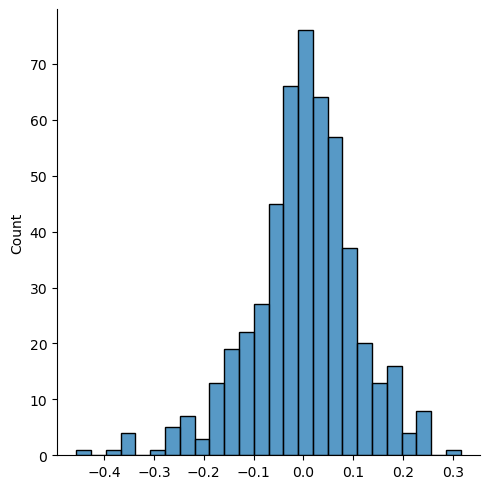

In [77]:
res = y_train - y_train_pred
sns.displot(res)

- the means seems to be around 0 and the distribution is also normal

### Predictions and evaluations on the test set

In [78]:
df_test.head(2)

,temp,hum,windspeed,cnt,yr,holiday,workingday,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sept,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed,weathersit_light_rain,weathersit_mist
184,29.793347,63.7917,5.459106,6043.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
535,32.082500,59.2083,7.625404,6211.0,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [79]:
df_test[x] = scaler.transform(df_test[x])
df_test.head(2)

,temp,hum,windspeed,cnt,yr,holiday,workingday,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sept,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed,weathersit_light_rain,weathersit_mist
184,0.831783,0.657364,0.084219,0.692706,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
535,0.901354,0.610133,0.153728,0.712034,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [80]:
y_test = df_test.pop('cnt')
X_test = df_test

In [81]:
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,temp,hum,windspeed,yr,holiday,workingday,season_spring,season_summer,season_winter,...,mnth_Oct,mnth_Sept,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tues,weekday_Wed,weathersit_light_rain,weathersit_mist
184,1.0,0.831783,0.657364,0.084219,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
535,1.0,0.901354,0.610133,0.153728,1,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
299,1.0,0.511964,0.837699,0.334206,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1
221,1.0,0.881625,0.437098,0.339570,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,1.0,0.817246,0.314298,0.537414,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [84]:
test_col = set(X_test_sm.columns)

In [85]:
train_col = set(X_train_new4.columns)

In [89]:
cols_to_drop = list(test_col - train_col)

In [90]:
cols_to_drop

['mnth_Jun',
 'weekday_Sat',
 'weekday_Wed',
 'mnth_May',
 'mnth_Aug',
 'mnth_Nov',
 'hum',
 'workingday',
 'weekday_Mon',
 'weekday_Thurs',
 'season_spring',
 'mnth_Oct',
 'season_summer',
 'weekday_Tues',
 'mnth_Mar',
 'weathersit_mist',
 'mnth_Feb',
 'weekday_Sun',
 'mnth_Dec',
 'mnth_Jul',
 'mnth_Sept',
 'mnth_Jan']

In [91]:
X_test_sm = X_test_sm.drop(cols_to_drop, axis = 1)

In [92]:
X_test_sm.head(2)

,const,temp,windspeed,yr,holiday,season_winter,weathersit_light_rain
184,1.0,0.831783,0.084219,0,1,0,0
535,1.0,0.901354,0.153728,1,0,0,0


In [93]:
y_test_pred = lm4.predict(X_test_sm)
y_test_pred

184    0.501281
535    0.854010
299    0.464939
221    0.583804
152    0.517871
         ...   
702    0.709060
127    0.442561
640    0.876928
72     0.272046
653    0.701048
Length: 220, dtype: float64

In [94]:
r2_score(y_true =y_test, y_pred = y_test_pred)

0.7518412352015953

In [95]:
r2_score(y_true =y_train, y_pred = y_train_pred)

0.7772053493974802

- this is the simplest model we could build. The r2 score values on the training and the test set are similar